Michał Szczurek Informatyka II rok, grupa wtorek 12:50 B

# 1. Narzędzie graficzne

In [47]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE =0.09 #0.002

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1: #POPRAWA NARZĘDZIA
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim()[1]- self.ax.get_xlim()[0],
                                                                    self.ax.get_ylim()[1]- self.ax.get_ylim()[0]])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else: 
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [48]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# 2. Funckja umożliwiająca wczytanie wielokąta z rysunku 

Wielokąt powinien być narysowany przeciwnie do ruchu wskazówek zegara.

<IPython.core.display.Javascript object>


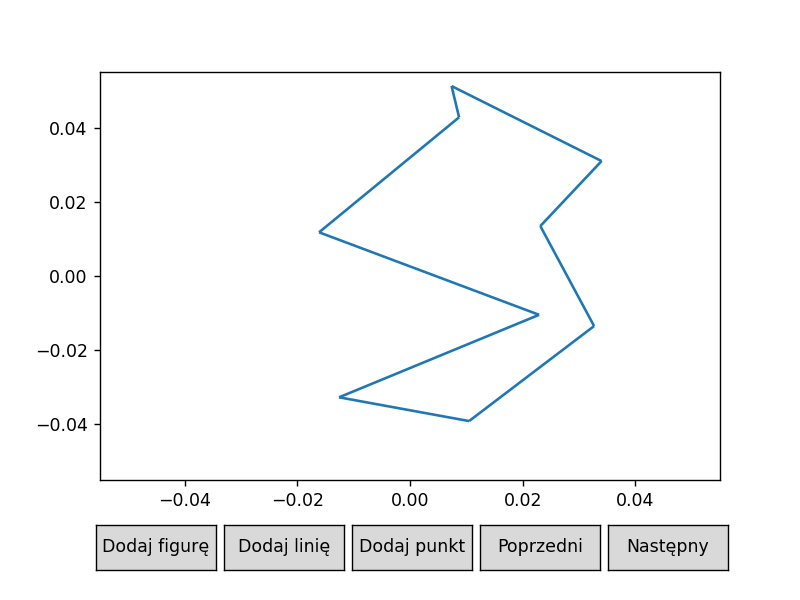

In [50]:
%matplotlib notebook
figure =Plot()
figure.draw()

# 3. Funkcja zwracająca punkty z rysunku 

In [51]:
def points_from_plot(plot):
    pts = []
    lines = plot.get_added_figure()[0].lines
    for l in lines:
        pts.append(l[0])
    return pts

In [52]:
points_from_plot(figure)

[(0.010481598761773875, -0.039109989802042645),
 (0.03265901811661258, -0.013497244704003417),
 (0.023122727794031933, 0.013463539609722075),
 (0.03398966327790291, 0.03098804941364365),
 (0.007376760052096448, 0.051208637648937794),
 (0.008707405213386782, 0.04278339255089855),
 (-0.016131304464032582, 0.011778490590114238),
 (0.022900953600483553, -0.010464156468709296),
 (-0.01258291736725839, -0.032706803527532836)]

# 4. Deklaracje pomocniczne

In [53]:
class Polygon:
    def __init__(self, tab):
        self.points = tab
        
def polygon_from_plot(plot):
    pts = []
    lines = plot.get_added_figure()[0].lines
    for l in lines:
        pts.append(l[0])
    return Polygon(pts)

# wyznacznik
def det(a, b, c):
    return a[0] * b[1] + b[0] * c[1] + c[0] * a[1] - c[0] * b[1] - a[0] * c[1] - b[0] * a[1]

def to_lines(tab):
    lines = []
    for i in range(1,len(tab)):
        lines.append((tab[i-1],tab[i]))
    return lines

# 5. Sprawdzanie czy wielokąt jest y-monotoniczny 

Wartość true oznacza monotoniczność. False- niemonotoniczność.

5.1 Implementacja

In [54]:
def y_monotone(polygon):
    
    # znalezienie najwyższego punktu
    highest_id = 0
    for (i,p) in enumerate(polygon.points):
        if p[1] > polygon.points[highest_id][1]:
            highest_id = i
        elif p[1] == polygon.points[highest_id][1] and p[0] > polygon.points[highest_id][0]:
            highest_id = i
    
    # przeglądanie punktów w lewym łańcuchu, aż napotkamy taki, że następny jest wyżej
    curr_id = highest_id
    while polygon.points[curr_id][1] >=  polygon.points[(curr_id + 1) % len(polygon.points)][1]:
        curr_id += 1
        if curr_id == len(polygon.points):
            curr_id = 0
        
    potential_lowest_id = curr_id
       
    # przeglądanie punktów w prawym łańcuchu, aż napotkamy taki, że następny jest wyżej lub dojdziemy do najniższego
    curr_id = highest_id
    while polygon.points[curr_id][1] >  polygon.points[(curr_id - 1) % len(polygon.points)][1]:
       
        curr_id -= 1
        if curr_id < 0:
            curr_id = len(polygon.points)-1

    return curr_id == potential_lowest_id
    

In [55]:
def strictly_y_monotone(polygon):
    highest_id = 0
    for (i,p) in enumerate(polygon.points):
        if p[1] > polygon.points[highest_id][1]:
            highest_id = i
    curr_id = highest_id
    while polygon.points[curr_id][1] >  polygon.points[(curr_id + 1) % len(polygon.points)][1]:
        curr_id += 1
        if curr_id == len(polygon.points):
            curr_id = 0
            
    potential_lowest_id = curr_id
    curr_id = highest_id
    while polygon.points[curr_id][1] >  polygon.points[(curr_id - 1) % len(polygon.points)][1]:
       
        curr_id -= 1
        if curr_id < 0:
            curr_id = len(polygon.points)-1

    return curr_id == potential_lowest_id

Wartość True oznacza monotoniczność. False- niemonotoniczność.

5.2 Bezpośrednio z wykresu

In [56]:
p = polygon_from_plot(figure)
print(y_monotone(p))
print(strictly_y_monotone(p))

True
True


5.3 Z wybranego zestawu punktów

In [57]:
# Przykładowe dane
data = [(0,1),(0,0),(1,0),(1,1)]


p = Polygon(data)
print(y_monotone(p))
print(strictly_y_monotone(p))

True
False


# 6. Klasyfikacja wierzchołków

Legenda: <br>
    zielony- wierzchołek początkowy <br>
    czerwony- wierzchołek końcowy <br>
    granatowy- wierzchołek łączący <br>
    jasnoniebieski- wierzchołek dzielący <br>
    brązowy- wierzchołek prawidłowy

6.1 Implementacja

In [58]:
def classify_vert(polygon, epsilon = 10**(-12)):
    
    def classify(a,b,c):
        if a[1] < b[1] > c[1]:
            if det(a, c, b) < -epsilon:
                beginning.append(b)
            elif det(a, c, b) > epsilon:
                dividing.append(b)
            else:
                 correct.append(b)
        elif a[1] > b[1] < c[1]:
            if det(a, c, b) < -epsilon:
                ending.append(b)
            elif det(a, c, b) > epsilon:
                connecting.append(b)
            else:
                correct.append(b)
        else:
            correct.append(b)
            
    beginning = []
    ending = []
    connecting = []
    dividing = []
    correct = []
    
    for i in range (1, len(polygon.points)-1):
        classify(polygon.points[i-1], polygon.points[i], polygon.points[i+1])
    
    classify(polygon.points[len(polygon.points)-1], polygon.points[0], polygon.points[1])
    classify(polygon.points[len(polygon.points)-2], polygon.points[len(polygon.points)-1], polygon.points[0])
    
    return beginning, ending, connecting, dividing, correct
                

In [59]:
def draw_classification(beginning, ending, connecting, dividing, correct, polygon):   
    scene = [Scene([PointsCollection(beginning, color = "limegreen"),
                   PointsCollection(ending, color = "red"),
                   PointsCollection(connecting, color = "mediumblue"),
                   PointsCollection(dividing, color = "lightskyblue"),
                   PointsCollection(correct, color = "brown")],
                  [LinesCollection(to_lines(polygon.points) + [(polygon.points[-1], polygon.points[0])], color = "black")])]
    plot = Plot(scene)
    plot.draw()

6.2 Bezpośrednio z wykresu

<IPython.core.display.Javascript object>


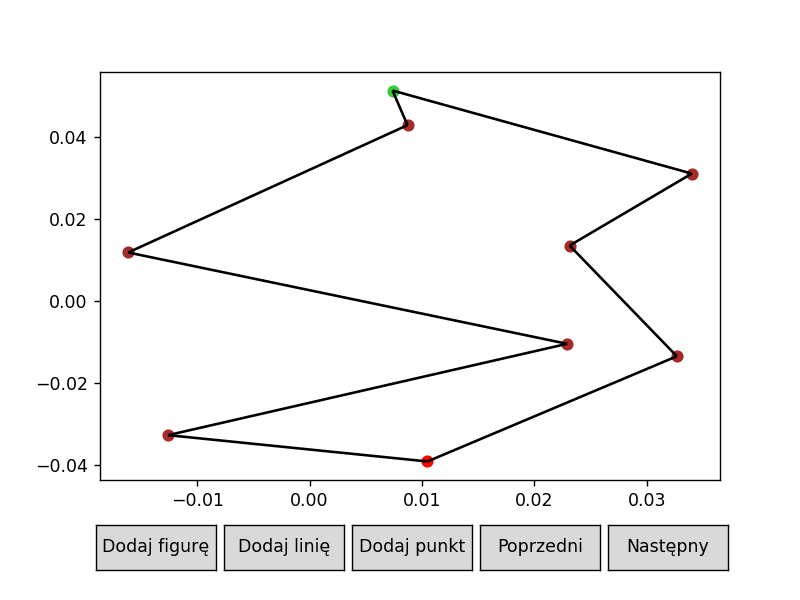

In [60]:
polygon = polygon_from_plot(figure)
(beg, end, con, div, cor) = classify_vert(polygon)
draw_classification(beg, end, con, div, cor, polygon)

6.3 Z wybranego zestawu punktów

<IPython.core.display.Javascript object>


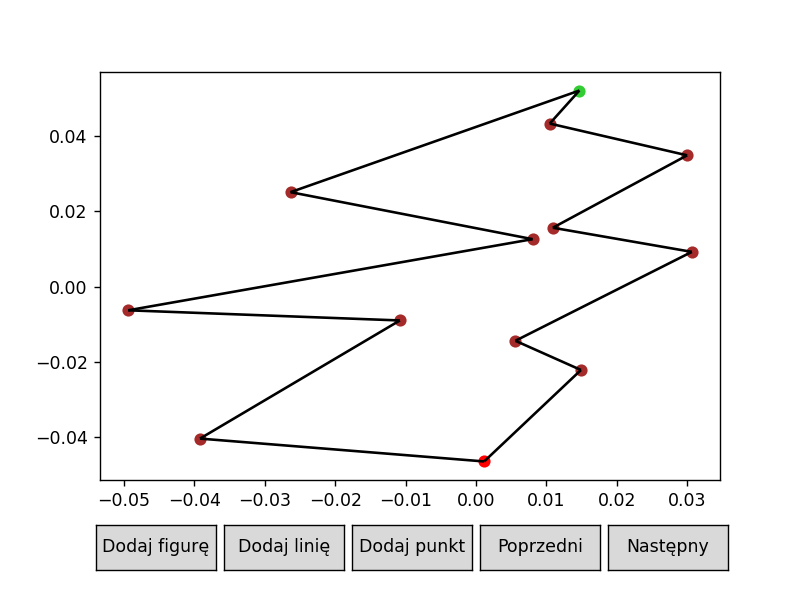

In [61]:
# Przykładowe dane
data = [(0.001167082632741609, -0.046389398481331626),
 (0.014917082632741621, -0.022124692598978674),
 (0.005602566503709355, -0.014373467108782595),
 (0.030663050374677106, 0.009217219165727222),
 (0.010925147148870648, 0.015620405440237031),
 (0.02999772779403194, 0.034829964263766444),
 (0.010481598761773875, 0.04325520936180566),
 (0.014695308439193228, 0.05201746426376644),
 (-0.026332917367258388, 0.025056679950040947),
 (0.008042082632741615, 0.01258731720494291),
 (-0.04939743349629065, -0.006285231814664935),
 (-0.01080872381887129, -0.008981310246037488),
 (-0.03919582059306484, -0.040323222010743384)]

polygon = Polygon(data)
(beg, end, con, div, cor) = classify_vert(polygon)
draw_classification(beg, end, con, div, cor, polygon)

# 7. Triangulacja wielkoątów monotonicznych

Legenda: <br>
    niebieski- wierzchołki, podczas sprawdzania, czy tworzą trójkąt należący do wielokata <br>
    czerwony- punkty na stosie <br>
    czarny- pozostałe punkty <br>

7.1 Implementacja i funkcje pomocnicze

In [62]:
def triangle_in_polygon(a, b, c, epsilon):
    # det a c b
    if c.chain == 'l':
        return det((a.x,a.y),(c.x,c.y),(b.x,b.y)) < -epsilon
    else:
        return det((a.x,a.y),(c.x,c.y),(b.x,b.y)) > epsilon

In [63]:
def stack_to_points(stack):
    res = []
    for p in stack:
        res.append((p.x,p.y))
    return res

In [64]:
def add_scenes(scenes, polygon, stack, lines):
      scenes.append(Scene([PointsCollection(polygon.points , color = "black"),
                            PointsCollection(stack_to_points(stack) , color = "red")],
                           [LinesCollection(to_lines(polygon.points).copy() +[(polygon.points[-1], polygon.points[0])], color = "black"),
                           LinesCollection(lines.copy(), color = "orange")]))

In [65]:
class Tri_point:
    def __init__ (self, x, y, chain, left, right):
        self.chain = chain
        self.x = x
        self.y = y
        self.left = left # lewy sąsiad jako krotka
        self.right = right # prawy sąsiad  jako krotka
    
    def are_neighbours(self, other):
        if self.left[0] == other.x and self.left[1] == other.y:
            return True
        if self.right[0] == other.x and self.right[1] == other.y:
            return True
        return False

In [66]:
def triangulation(polygon, epsilon = 10**(-12)):
    
    if not strictly_y_monotone(polygon):
        return
    
    points = [] # przechowuje punkty w postaci (x,y,'l'/'r'/'b') l- lewy łańcuch r- prawy b- należy do obu
    highest_id = 0
    lowest_id = 0
    if polygon.points == []:
        print("Coś poszło nie tak podczas wczytywania wielokąta z wykresu (Wina narzędzia graficznego). Spróbuj narysować go ponowanie.")
        return
    
    # Znajduje najwyższy i najniższy punkt
    for (i,p) in enumerate(polygon.points):
        if p[1] > polygon.points[highest_id][1]:
            highest_id = i
        if p[1] < polygon.points[lowest_id][1]:
            lowest_id = i
    
    points.append(Tri_point(polygon.points[highest_id][0], polygon.points[highest_id][1], 'b',
                                 polygon.points[(highest_id -1 )% len(polygon.points)],  
                                 polygon.points[(highest_id +1 )% len(polygon.points)]))
                                   
                            
    
    l_id = highest_id + 1
    r_id = highest_id - 1
    
    # dodaje wyższy z punktów i przypisuje mu symbol łańcucha, działa podobnie jak merge z mergesort
    while polygon.points[l_id % len(polygon.points)] is not polygon.points[lowest_id] and polygon.points[r_id % len(polygon.points)] is not polygon.points[lowest_id]:
        
        if polygon.points[l_id % len(polygon.points)][1] > polygon.points[r_id % len(polygon.points)][1]:
            tmp_id = l_id % len(polygon.points)
            points.append(Tri_point(polygon.points[tmp_id][0], polygon.points[tmp_id][1], 'l',
                                 polygon.points[(tmp_id -1) % len(polygon.points)],  
                                 polygon.points[(tmp_id +1)% len(polygon.points)]))
            l_id += 1
        else:
            tmp_id = r_id % len(polygon.points)
            points.append(Tri_point(polygon.points[tmp_id][0], polygon.points[tmp_id][1], 'r',
                                 polygon.points[(tmp_id -1) % len(polygon.points)],  
                                 polygon.points[(tmp_id +1) % len(polygon.points)]))
            r_id -= 1
    
    # jeśli w jakimś łańcuchu są jeszcze nieprzejrzane punkty to zostają dodane
    while polygon.points[l_id % len(polygon.points)] is not polygon.points[lowest_id]:
        tmp_id = l_id % len(polygon.points)
        points.append(Tri_point(polygon.points[tmp_id][0], polygon.points[tmp_id][1], 'l',
                                 polygon.points[(tmp_id -1) % len(polygon.points)],  
                                 polygon.points[(tmp_id +1) % len(polygon.points)]))
        l_id += 1
        
    while polygon.points[r_id % len(polygon.points)] is not polygon.points[lowest_id]:
        tmp_id = r_id % len(polygon.points)
        points.append(Tri_point(polygon.points[tmp_id][0], polygon.points[tmp_id][1], 'r',
                                 polygon.points[(tmp_id -1) % len(polygon.points)],  
                                 polygon.points[(tmp_id +1) % len(polygon.points)]))
        r_id -= 1    
    
    points.append(Tri_point(polygon.points[lowest_id][0], polygon.points[lowest_id][1], 'b',
                                 polygon.points[(lowest_id -1) % len(polygon.points)],  
                                 polygon.points[(lowest_id +1) % len(polygon.points)]))
    
    # Przeglądanie posortowanych punktów
    stack = []
    stack.append(points[0])
    stack.append(points[1])
    scenes=[(Scene([PointsCollection(polygon.points , color = "black"),
                            PointsCollection(stack_to_points(stack) , color = "red")],
                           [LinesCollection(to_lines(polygon.points) + [(polygon.points[-1], polygon.points[0])], color = "black")]))]
                  
    lines = []
    for i in range(2, len(points)-1):
        curr = points[i]
        
        # Jeśli punkty należą do innego łańcucha
        if curr.chain != stack[-1].chain:
            for v in stack:
                if (not v.are_neighbours(curr)):
                    lines.append(((v.x,v.y),(curr.x,curr.y)))
                    stack = [points[i-1], points[i]]
                    add_scenes(scenes,polygon, stack, lines)
        
        # Jeśli punkty należą do tego samego łańcucha
        else:
            j = len(stack) -1
            while j > 0:               
                scenes.append(Scene([PointsCollection(polygon.points , color = "black"),
                            PointsCollection(stack_to_points(stack) , color = "red"),
                            PointsCollection([(curr.x, curr.y),(stack[j-1].x, stack[j-1].y),(stack[j].x, stack[j].y)], color = "blue")],
                           [LinesCollection(to_lines(polygon.points) +[(polygon.points[-1], polygon.points[0])], color = "black"),
                           LinesCollection(lines.copy(), color = "orange")]))
                  
                
                if  triangle_in_polygon(stack[j-1], stack[j], curr, epsilon):
                    if not curr.are_neighbours(stack[j-1]):
                        lines.append(((curr.x, curr.y),(stack[j-1].x, stack[j-1].y)))
                        stack.pop(len(stack) -1)
                    j -= 1  
                else:
                    j=-1
            stack.append(curr)       
            add_scenes(scenes,polygon, stack, lines)
                  
    for p in stack:
        if not p.are_neighbours(points[len(points) -1]):
            lines.append(((points[len(points) -1].x, points[len(points) -1].y),(p.x,p.y)))   
    
    stack = []
    add_scenes(scenes,polygon, stack, lines)                      
    return (lines, scenes)
 

7.1 Bezpośrednio z wykresu

Ilość dodanych przekątnych:  6


<IPython.core.display.Javascript object>


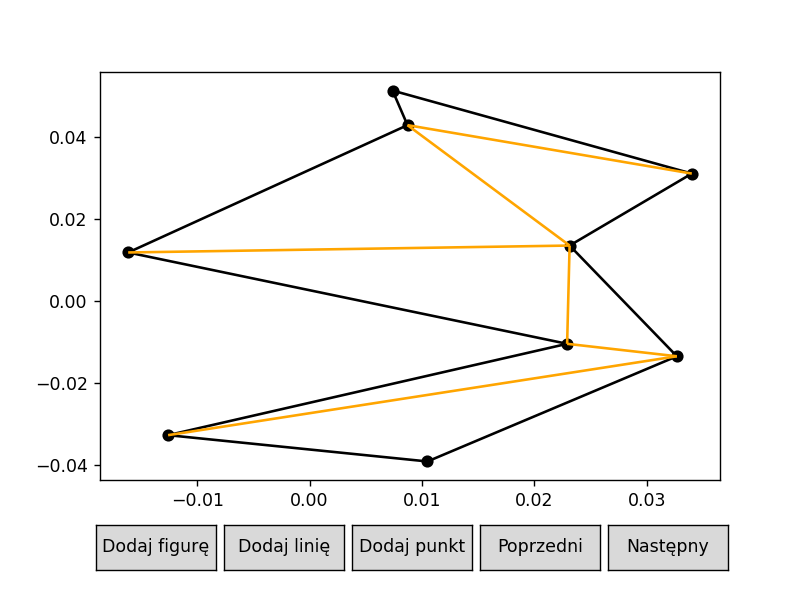

In [69]:
polygon = polygon_from_plot(figure)
(lines, scenes) = triangulation(polygon) # lines to linie utworzone w wyniku triaangulacji
plot = Plot(scenes)
print("Ilość dodanych przekątnych: ", len(lines))
plot.draw()

7.2 Z wybranego zestawu danych

Ilość dodanych przekątnych:  6


<IPython.core.display.Javascript object>


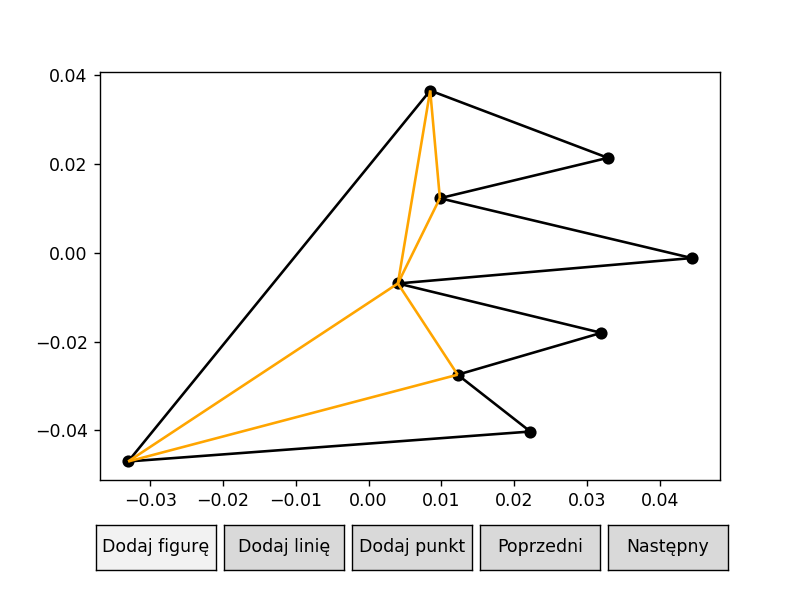

In [70]:
data =[(0.008455141129032256, 0.03657890712513644),
 (-0.03301663306451613, -0.0469995242474126),
 (0.02220514112903227, -0.04025932816898122),
 (0.01222530241935485, -0.02745295561996161),
 (0.031963205645161294, -0.018016681110157695),
 (0.004019657258064524, -0.006895357580745928),
 (0.04438256048387097, -0.0011661909140792542),
 (0.00978578629032259, 0.012314201242783498),
 (0.03285030241935484, 0.021413465948665847)]

(diagonals ,scenes) = triangulation(Polygon(data))
print("Ilość dodanych przekątnych: ", len(diagonals))
plot = Plot(scenes)
plot.draw()

# 8. Zestawy danych omówione w sprawozdaniu

8.1 Dane do sprawdzania monotoniczności

In [ ]:
1. 
[(-0.001715981883387424, -0.04618719568439559),
 (0.01646950198758032, -0.021585479998121063),
 (0.004050147148870642, -0.025629597645179893),
 (0.01624772779403194, 0.024921872943055423),
 (0.0031630503746770955, 0.006049323923447564),
 (0.010481598761773875, 0.043794421962663255),
 (-0.02855065930274226, -0.028325676076552446)]

2. 
[(0.01402998585854806, -0.03944699960596421),
 (0.024231598761773873, -0.017204352547140672),
 (0.010481598761773875, -0.0013648917628269475),
 (0.024675147148870646, 0.02964001019795738),
 (0.008485631019838388, 0.05188265725678093),
 (-0.025889368980161614, 0.0020052062763887407),
 (0.012255792310160968, -0.02360753882165048),
 (-0.007925659302742263, -0.04517616627263088)]

3. 
[(0, 0),(0.5,0), (1,0), (1,1), (0,1)]

8.2 Dane do klasyfikacji wierzchołków

In [ ]:
[(-0.011948084677419354, -0.0038622693454518076),
 (-0.026141633064516133, -0.037563249737608675),
 (-0.006625504032258062, -0.020375749737608667),
 (-0.005738407258064515, -0.012287514443491021),
 (0.001801915322580644, -0.0200387399336871),
 (-0.008399697580645155, -0.036889230129765534),
 (-0.0163835685483871, -0.035541190914079264),
 (-0.005294858870967742, -0.04935859287486358),
 (0.014221270161290323, -0.03587820071800083),
 (0.0037978830645161304, -0.02745295561996161),
 (0.04637852822580646, 0.030849740458469777),
 (0.0004712701612903242, -0.0004921713062361194),
 (0.020874495967741935, 0.03792694634082272),
 (-0.014165826612903228, 0.05073331888984231),
 (0.005350302419354844, 0.0348938581055286),
 (-0.015052923387096774, 0.02107645614474428),
 (-0.021706149193548387, 0.046015181634940366),
 (-0.0387827620967742, 0.04534116202709723),
 (-0.04410534274193549, 0.02107645614474428),
 (-0.035234375000000005, 0.016021309085920754),
 (-0.04787550403225807, -0.027789965423883185),
 (-0.02259324596774194, 0.0032149365369011362)]

8.3 Dane do triangulacji

In [ ]:
1.    
[(0.001167082632741609, -0.046389398481331626),
 (0.014917082632741621, -0.022124692598978674),
 (0.005602566503709355, -0.014373467108782595),
 (0.030663050374677106, 0.009217219165727222),
 (0.010925147148870648, 0.015620405440237031),
 (0.02999772779403194, 0.034829964263766444),
 (0.010481598761773875, 0.04325520936180566),
 (0.014695308439193228, 0.05201746426376644),
 (-0.026332917367258388, 0.025056679950040947),
 (0.008042082632741615, 0.01258731720494291),
 (-0.04939743349629065, -0.006285231814664935),
 (-0.01080872381887129, -0.008981310246037488),
 (-0.03919582059306484, -0.040323222010743384)]

2.
[(0.008455141129032256, 0.03657890712513644),
 (-0.03301663306451613, -0.0469995242474126),
 (0.02220514112903227, -0.04025932816898122),
 (0.01222530241935485, -0.02745295561996161),
 (0.031963205645161294, -0.018016681110157695),
 (0.004019657258064524, -0.006895357580745928),
 (0.04438256048387097, -0.0011661909140792542),
 (0.00978578629032259, 0.012314201242783498),
 (0.03285030241935484, 0.021413465948665847)]

3.
[(0.040864663277902905, -0.039109984659681137),
 (0.010481598761773875, 0.049860603575613005),
 (-0.01879259478661323, 0.034695162399142415),
 (0.0036065987617738687, 0.029303005536397322),
 (-0.043631304464032586, 0.017844672203063988),
 (0.002941276181128716, 0.009756436908946328),
 (-0.040082917367258386, -0.0006908670126222899),
 (0.019130792310160974, -0.009453121914583085),
 (-0.005486143173710004, -0.024281553287132107)]

4.
[(-0.028772433496290648, -0.0374249407824348),
 (-0.014357110915645482, -0.03405484274321911),
 (-0.009478078657580963, -0.026640627056944602),
 (-0.005486143173710004, -0.02057445058635636),
 (-0.0037119496253228967, -0.014171264311846551),
 (-0.0021595302704841973, -0.008105087841258324),
 (-0.0014942076898390305, -1.6852547140663865e-05),
 (-0.0010506593027422573, 0.008071382746976982),
 (-0.00016356252854871078, 0.01615961804109463),
 (5.821166499968278e-05, 0.023910843531290707),
 (-0.00038533672209709047, 0.028965990590114246),
 (-0.002381304464032577, 0.03604319647246719),
 (-0.00637323994790355, 0.04312040235482012)]

5.
[(-0.000607110915645484, -0.044502146664787745),
 (0.019130792310160974, -0.0320327839196897),
 (0.0273364374714513, 0.007397363139133847),
 (0.025340469729515813, 0.034695157256780906),
 (0.012477566503709361, 0.048512559217565226),
 (0.0018324052133867758, 0.03705422588423189),
 (0.001167082632741609, 0.01717064745285933),
 (-0.0028248528511293503, -0.01316023490008185)]

6.
[(0.006711437471451295, -0.0374249407824348),
 (0.022235631019838387, -0.02697763686086617),
 (0.030663050374677106, -0.012486215292238714),
 (0.029332405213386772, -0.0020389113706700823),
 (0.022900953600483553, 0.005375304315604429),
 (-0.006816788335000323, 0.010767461178349536),
 (0.0273364374714513, 0.02020373568815345),
 (0.020904985858548067, 0.03941329451168288),
 (-0.0012724334962906508, 0.050197608237173064),
 (-0.02544582059306484, -0.043491117253023036)]